In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
import spacy
from nltk.corpus import stopwords
from collections import Counter
%matplotlib inline
sns.set_style("darkgrid")
colors = ['#651FFF', '#00B0FF', '#1DE9B6', '#00E676', '#FF9100', '#FF3D00']
sns.set_palette(colors)

### Introduction
For this exercise we will be digging into a dataset of housing prices in Melbourne Australia. The data was taken from Kaggle and can be found here: https://www.kaggle.com/anthonypino/melbourne-housing-market/home. 

The dataset pulls a number of features about different sales that occurred in the city and it's surrounding suburbs.

From this excercise, we will be using the dataset's features, plus some engineered features to predict the price of homes on the market. From preliminary looks at the dataset, it seems like we will have a lot of null values that will greatly reduce the amount of values that we will use to predict with. From the table described below, the max price looks like it considerably higher than the 75%, meaning we have some outliers that we will have to remove

In [64]:
mel_raw = pd.read_csv('Melbourne_housing_FULL.csv')

mel_raw.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,34857.000000,2.724700e+04,34856.000000,34856.000000,26640.000000,26631.000000,26129.000000,23047.000000,13742.00000,15551.000000,26881.000000,26881.000000,34854.000000
mean,3.031012,1.050173e+06,11.184929,3116.062859,3.084647,1.624798,1.728845,593.598993,160.25640,1965.289885,-37.810634,145.001851,7572.888306
std,0.969933,6.414671e+05,6.788892,109.023903,0.980690,0.724212,1.010771,3398.841946,401.26706,37.328178,0.090279,0.120169,4428.090313
min,1.000000,8.500000e+04,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1196.000000,-38.190430,144.423790,83.000000
25%,2.000000,6.350000e+05,6.400000,3051.000000,2.000000,1.000000,1.000000,224.000000,102.00000,1940.000000,-37.862950,144.933500,4385.000000
50%,3.000000,8.700000e+05,10.300000,3103.000000,3.000000,2.000000,2.000000,521.000000,136.00000,1970.000000,-37.807600,145.007800,6763.000000
75%,4.000000,1.295000e+06,14.000000,3156.000000,4.000000,2.000000,2.000000,670.000000,188.00000,2000.000000,-37.754100,145.071900,10412.000000
max,16.000000,1.120000e+07,48.100000,3978.000000,30.000000,12.000000,26.000000,433014.000000,44515.00000,2106.000000,-37.390200,145.526350,21650.000000


In [65]:
nullvals = pd.DataFrame(mel_raw.isna().sum())
nullvals

,0
Suburb,0
Address,0
Rooms,0
Type,0
Price,7610
Method,0
SellerG,0
Date,0
Distance,1
Postcode,1


In [66]:
mel = mel_raw.dropna()
mel.shape

(8887, 21)

Much like we had predicted, there are a bunch of null values in the dataset that we needed to get rid of. Thankfully dropping those still leaves us with a little less than 9000 values for us to work with. From here we will begin to take a look at how the data is shaped, then possibly clean up the dataset even more.

### Explore the Data
First taking a look at the distribution of the prices, it comfirms that we might have a few outliers that are skewing our distribution away from a normal distribution. This is confirmed when viewing the log scaled version of the data. It seems as if the brawn of our data fits into a range between about 200,000 and 1,000,000

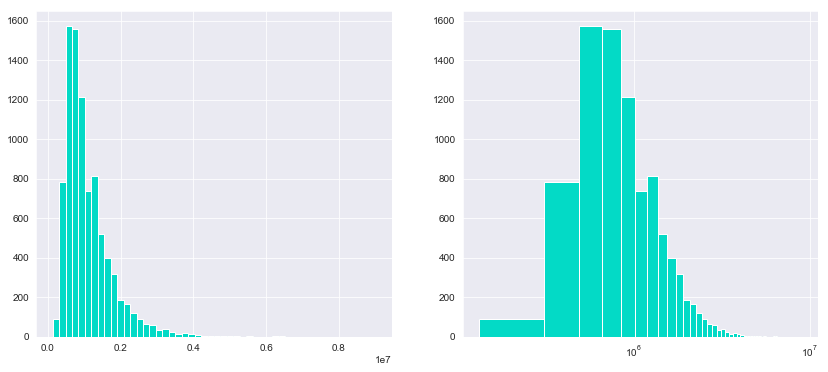

In [68]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(mel.Price, bins=50, color='#03DAC6')
plt.subplot(1,2,2)
plt.hist(mel.Price, bins=50, color='#03DAC6')
plt.xscale('log')
plt.show()

Below, we will take the year a house was built to create a new 'age' feature. We will also split the month, year, and day apart from the date column. 

In [7]:
mel.Date = pd.to_datetime(mel.Date)
mel['Year'] = pd.DatetimeIndex(mel.Date).year
mel['Month'] = pd.DatetimeIndex(mel.Date).month
mel['Day'] = pd.DatetimeIndex(mel.Date).day
mel['Age'] = mel['Year'] - mel['YearBuilt']
mel[['Date','Year','Month','Day','YearBuilt','Age']].head()

/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

,Date,Year,Month,Day,YearBuilt,Age
2,2016-04-02,2016,4,2,1900.0,116.0
4,2017-04-03,2017,4,3,1900.0,117.0
6,2016-04-06,2016,4,6,2014.0,2.0
11,2016-07-05,2016,7,5,1910.0,106.0
14,2016-08-10,2016,8,10,1890.0,126.0


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


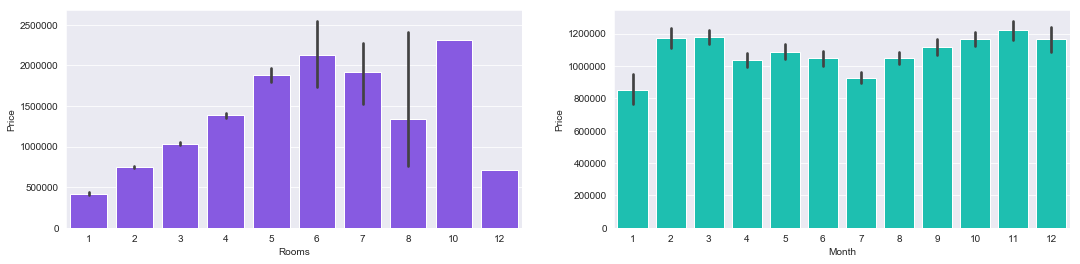

In [8]:
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
sns.barplot(data=mel, x='Rooms', y='Price', color='#7F44F7')
plt.subplot(1,2,2)
sns.barplot(data=mel, x='Month', y='Price', color='#03DAC6')
plt.show()

The analysis of between how months affect the price seems pretty normal. Seems as if there is high variation among pretty much all months, and that prices seem to be higher at the beginning and the end of the year (summertime in the southern hemisphere). The single anomaly being January having an abnormaly low average price, this might be explained by the extreme weather in what is essentially the heat of summerin Australia. 

Looking at the rooms distribution, it is odd how it jumps from 8 rooms up to 10 without hitting 9. Also the lack of back indicating variation on 10 room or 12 room houses seems to indicate that their are only one or so datapoints that have 10 or 12 rooms

In [9]:
mel.loc[mel.Rooms>8].sort_values(by='Rooms', ascending=False)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Year,Month,Day,Age
27150,Melton,213 Station Rd,12,h,710000.0,S,PRDNationwide,2017-11-11,31.7,3337.0,...,1970.0,Melton City Council,-37.68830,144.57760,Western Victoria,3600.0,2017,11,11,47.0
25717,Burwood,79 Elgar Rd,10,h,2315000.0,SP,Buxton,2017-10-28,10.4,3125.0,...,2015.0,Monash City Council,-37.84461,145.10968,Southern Metropolitan,5678.0,2017,10,28,2.0


In [10]:
mel.Price.loc[mel.Rooms>=7]

616      2950000.0
1090     2600000.0
2375     1205000.0
5409      770000.0
7134      881000.0
11215    1300000.0
14342    2705000.0
16765    1642000.0
18309    2000000.0
22572     741000.0
25717    2315000.0
27150     710000.0
32586    1950000.0
Name: Price, dtype: float64

In [11]:
mel = mel.drop(mel[mel['Rooms']>=7].index)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


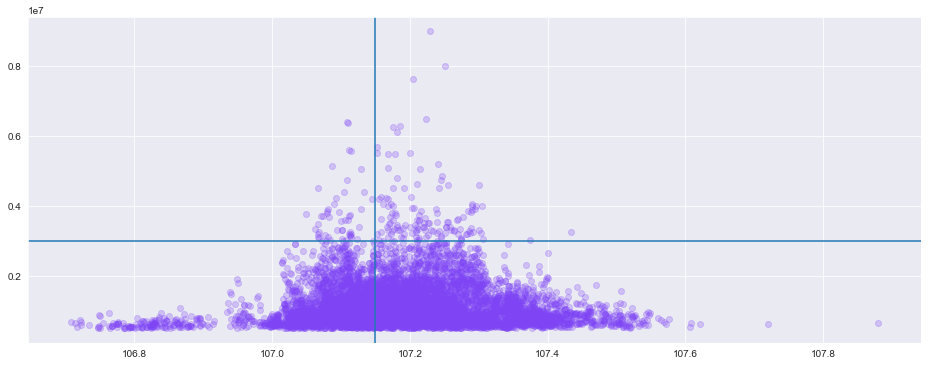

In [12]:
top_prices = mel.loc[mel['Price']>500000]
#top_prices.sort_values(by='Price', ascending=False).head(10)
top_prices['location'] = top_prices['Lattitude'] + top_prices['Longtitude']

melbourne = -37.8136 + 144.9631

plt.figure(figsize=(16,6))
plt.scatter(data=top_prices, x='location', y='Price', alpha=.25, color='#7F44F7')
plt.axvline(x=melbourne)
plt.axhline(y=3000000)
plt.show()

In [13]:
mel.dtypes

Suburb                   object
Address                  object
Rooms                     int64
Type                     object
Price                   float64
Method                   object
SellerG                  object
Date             datetime64[ns]
Distance                float64
Postcode                float64
Bedroom2                float64
Bathroom                float64
Car                     float64
Landsize                float64
BuildingArea            float64
YearBuilt               float64
CouncilArea              object
Lattitude               float64
Longtitude              float64
Regionname               object
Propertycount           float64
Year                      int64
Month                     int64
Day                       int64
Age                     float64
dtype: object

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


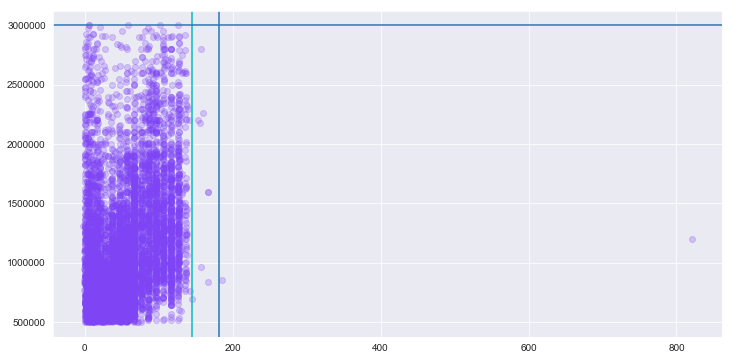

In [15]:
mel = mel.drop(mel[mel['Price']>3000000].index)
top_prices = mel.loc[mel['Price']>500000]
#top_prices.sort_values(by='Price', ascending=False).head(10)
top_prices['location'] = top_prices['Lattitude'] + top_prices['Longtitude']
top_prices['age'] = mel['Age']

melbourne = -37.8136 + 144.9631

plt.figure(figsize=(12,6))
plt.scatter(data=top_prices, x='age', y='Price', alpha=.25, color='#7F44F7')
# melbourne was founded in 1835
plt.axvline(x=182)
plt.axvline(x=145, color='c')
plt.axhline(y=3000000)
plt.show()

In [16]:
mel.loc[mel.Age>145].sort_values(by='YearBuilt')

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,Year,Month,Day,Age
16424,Mount Waverley,5 Armstrong St,3,h,1200000.0,VB,McGrath,2017-06-24,14.2,3149.0,...,1196.0,Monash City Council,-37.86788,145.12121,Eastern Metropolitan,13366.0,2017,6,24,821.0
3533,Collingwood,2/79 Oxford St,2,u,855000.0,S,Nelson,2016-03-09,1.6,3066.0,...,1830.0,Yarra City Council,-37.80420,144.98450,Northern Metropolitan,4553.0,2016,3,9,186.0
8030,Prahran,602/220 Commercial Rd,2,u,841000.0,S,hockingstuart,2017-03-18,4.5,3181.0,...,1850.0,Stonnington City Council,-37.84700,144.99360,Southern Metropolitan,7717.0,2017,3,18,167.0
8935,Richmond,22a Stanley St,3,h,1600000.0,S,Biggin,2016-09-24,2.6,3121.0,...,1850.0,Yarra City Council,-37.82330,144.99470,Northern Metropolitan,14949.0,2016,9,24,166.0
9626,St Kilda,51/167 Fitzroy St,3,u,1600000.0,PI,Kay,2017-02-25,6.1,3182.0,...,1850.0,Port Phillip City Council,-37.85840,144.98020,Southern Metropolitan,13240.0,2017,2,25,167.0
9133,South Melbourne,352 Moray St,4,h,2260000.0,PI,Marshall,2016-07-05,2.1,3205.0,...,1856.0,Port Phillip City Council,-37.83770,144.96530,Southern Metropolitan,5943.0,2016,7,5,160.0
9143,South Melbourne,315 Moray St,4,h,2180000.0,S,Marshall,2016-10-12,2.1,3205.0,...,1860.0,Port Phillip City Council,-37.83600,144.96500,Southern Metropolitan,5943.0,2016,10,12,156.0
14012,Carlton,2/100 Keppel St,2,t,960000.0,VB,Nelson,2017-05-20,1.8,3053.0,...,1860.0,Melbourne City Council,-37.79470,144.97240,Northern Metropolitan,6786.0,2017,5,20,157.0
18722,South Melbourne,26 Bridport St,3,h,2800000.0,VB,Greg,2017-07-15,1.9,3205.0,...,1860.0,Port Phillip City Council,-37.83863,144.96208,Southern Metropolitan,5943.0,2017,7,15,157.0
7787,Port Melbourne,175 Stokes St,3,h,2200000.0,S,Greg,2016-03-12,3.8,3207.0,...,1863.0,Melbourne City Council,-37.83810,144.93910,Southern Metropolitan,8648.0,2016,3,12,153.0


In [17]:
mel = mel.drop(mel[mel['Age']>145].index)

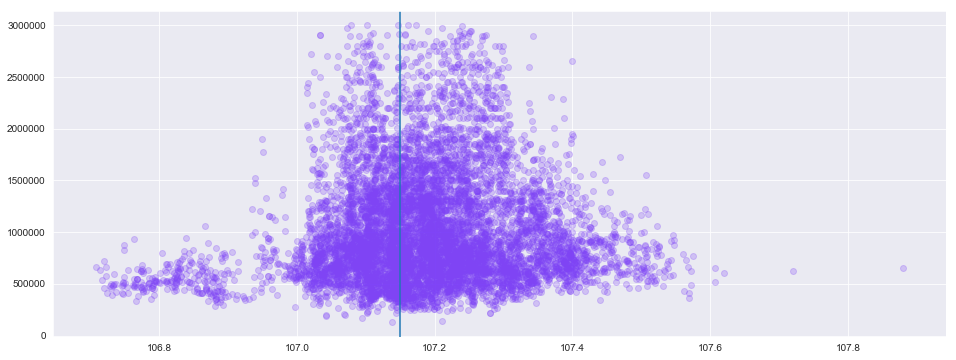

In [18]:
mel['location'] = mel['Lattitude'] + mel['Longtitude']

melbourne = -37.8136 + 144.9631

plt.figure(figsize=(16,6))
plt.scatter(data=mel, x='location', y='Price', alpha=.25, color='#7F44F7')
plt.axvline(x=melbourne)
plt.show()

In [19]:
mel.location.sort_values(ascending=False).head(20)

14426    107.87950
19248    107.71998
19732    107.62050
23922    107.60759
22003    107.60695
23660    107.57550
16423    107.57245
26553    107.57155
21590    107.56896
26711    107.56870
34543    107.56825
15153    107.56463
31405    107.56253
18114    107.56084
34542    107.54789
15152    107.54712
31684    107.54628
15808    107.54619
17662    107.54378
16810    107.54267
Name: location, dtype: float64

In [20]:
mel['fromCenter'] = mel.location - melbourne
mel.loc[mel.location>107.600].sort_values(by='location')

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Lattitude,Longtitude,Regionname,Propertycount,Year,Month,Day,Age,location,fromCenter
22003,Mount Evelyn,4 Longview Rd,3,h,515000.0,S,Ray,2017-08-19,31.6,3796.0,...,-37.78495,145.39190,Eastern Victoria,3532.0,2017,8,19,47.0,107.60695,0.45745
23922,Mount Evelyn,84 Bailey Rd,4,h,655000.0,S,Prof.,2017-07-10,31.6,3796.0,...,-37.78356,145.39115,Eastern Victoria,3532.0,2017,7,10,37.0,107.60759,0.45809
19732,Whittlesea,30 Sherwin St,3,h,601000.0,S,Ray,2017-07-29,35.5,3757.0,...,-37.51232,145.13282,Northern Victoria,2170.0,2017,7,29,21.0,107.62050,0.47100
19248,Yarra Glen,15 Yarra St,3,h,620000.0,SP,Buckingham,2017-07-22,31.4,3775.0,...,-37.65391,145.37389,Northern Victoria,1160.0,2017,7,22,42.0,107.71998,0.57048
14426,Healesville,15A Westmount Rd,3,h,650000.0,SP,McGrath,2017-01-07,45.2,3777.0,...,-37.64685,145.52635,Northern Victoria,3307.0,2017,1,7,8.0,107.87950,0.73000


In [21]:
mel = mel.drop(mel[mel.location>107.600].index)

In [22]:
mel.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount,Year,Month,Day,Age,location,fromCenter
count,8678.000000,8.678000e+03,8678.000000,8678.000000,8678.000000,8678.000000,8678.000000,8678.000000,8678.000000,8678.000000,8678.000000,8678.000000,8678.000000,8678.000000,8678.000000,8678.000000,8678.000000,8678.000000,8678.000000
mean,3.066375,1.034135e+06,11.264785,3110.682185,3.047361,1.616962,1.674464,515.733579,145.771789,1966.247407,-37.803756,144.990311,7483.468772,2016.724591,6.716294,15.926942,50.477184,107.186555,0.037055
std,0.932044,5.373030e+05,6.824442,112.552588,0.937824,0.682752,0.961478,1068.317859,84.184650,35.641981,0.091115,0.119456,4397.116597,0.657206,2.952146,8.185231,35.569298,0.122328,0.122328
min,1.000000,1.310000e+05,0.000000,3000.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1872.000000,-38.174360,144.423790,249.000000,2016.000000,1.000000,1.000000,-2.000000,106.707840,-0.441660
25%,2.000000,6.350000e+05,6.400000,3043.000000,2.000000,1.000000,1.000000,208.000000,99.000000,1950.000000,-37.858100,144.917600,4380.000000,2016.000000,4.000000,9.000000,17.000000,107.112510,-0.036990
50%,3.000000,8.850000e+05,10.400000,3082.000000,3.000000,2.000000,2.000000,467.000000,130.000000,1970.000000,-37.797065,144.997260,6567.000000,2017.000000,7.000000,16.000000,47.000000,107.182200,0.032700
75%,4.000000,1.307125e+06,14.000000,3150.000000,4.000000,2.000000,2.000000,650.000000,177.000000,2000.000000,-37.747500,145.064400,10331.000000,2017.000000,9.000000,24.000000,68.000000,107.258200,0.108700
max,6.000000,3.000000e+06,47.400000,3977.000000,9.000000,8.000000,10.000000,42800.000000,3112.000000,2019.000000,-37.407200,145.482730,21650.000000,2018.000000,12.000000,30.000000,145.000000,107.575500,0.426000


In [23]:
mel.dtypes

Suburb                   object
Address                  object
Rooms                     int64
Type                     object
Price                   float64
Method                   object
SellerG                  object
Date             datetime64[ns]
Distance                float64
Postcode                float64
Bedroom2                float64
Bathroom                float64
Car                     float64
Landsize                float64
BuildingArea            float64
YearBuilt               float64
CouncilArea              object
Lattitude               float64
Longtitude              float64
Regionname               object
Propertycount           float64
Year                      int64
Month                     int64
Day                       int64
Age                     float64
location                float64
fromCenter              float64
dtype: object

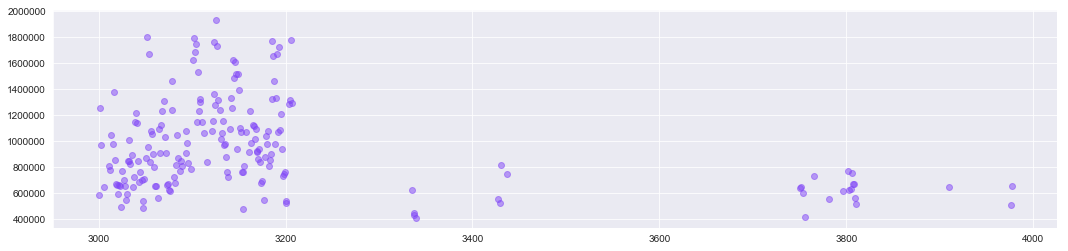

In [24]:
post_plt = pd.DataFrame(mel[['Postcode','Price']].groupby('Postcode')['Price'].mean())
post_plt.reset_index(level=0, inplace=True)

plt.figure(figsize=(18,4))
plt.scatter(data=post_plt, x='Postcode', y='Price', color='#7F44F7', alpha=.5)
plt.show()

In [25]:
#seller = mel_raw.groupby('SellerG')['Price'].nunique().sort_values(ascending=False).head(40)
seller_plt = pd.DataFrame(mel[['SellerG','Price']].groupby('SellerG')['Price'].mean().sort_values(ascending=False))
seller_plt['count'] = mel.groupby('SellerG')['Price'].nunique()
seller_plt.reset_index(level=0, inplace=True)
seller_plt.sort_values(by='Price', ascending=False).head(20)

,SellerG,Price,count
0,Lucas,2.450000e+06,1
1,Kelly,2.400000e+06,1
2,Walsh,2.310000e+06,1
3,Upper,2.100000e+06,1
4,Brace,2.000000e+06,1
5,Nick,1.892800e+06,20
6,Private/Tiernan's,1.880000e+06,1
7,Darras,1.870000e+06,1
8,WHITEFOX,1.820000e+06,1
9,Follett,1.820000e+06,1


In [26]:
mel.shape

(8678, 27)

In [27]:
top_seller = seller_plt.sort_values(by='count', ascending=False).head(60)
worst_seller = seller_plt.sort_values(by='count', ascending=False).tail(328)
top_list = top_seller.SellerG.values
worst_list = worst_seller.SellerG.values

In [28]:
dummies = pd.get_dummies(mel[['Type', 'Method']])

In [29]:
# Create dummies for some of the features
mel = mel.join(dummies)

In [30]:
mel.Regionname.unique()

array(['Northern Metropolitan', 'Western Metropolitan',
       'Southern Metropolitan', 'Eastern Metropolitan',
       'South-Eastern Metropolitan', 'Northern Victoria',
       'Eastern Victoria', 'Western Victoria'], dtype=object)

In [31]:
mel.Suburb = mel.Suburb.astype('category')
#mel.Type = mel.Type.astype('category')
mel.SellerG = mel.SellerG.astype('category')
#mel.Method = mel.Method.astype('category')
mel.Regionname = mel.Regionname.astype('category')
mel.CouncilArea = mel.CouncilArea.astype('category')

In [32]:
# Create Categories for some of the data
mel['suburbCodes'] = mel.Suburb.cat.codes
#mel['typeCodes'] = mel.Type.cat.codes
#mel['methodCodes'] = mel.Method.cat.codes
mel['sellerCodes'] = mel.SellerG.cat.codes
mel['regionCodes'] = mel.Regionname.cat.codes
mel['councilCodes'] = mel.CouncilArea.cat.codes
mel.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Type_u,Method_PI,Method_S,Method_SA,Method_SP,Method_VB,suburbCodes,sellerCodes,regionCodes,councilCodes
2,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,2016-04-02,2.5,3067.0,...,0,0,1,0,0,0,0,21,2,31
4,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,2017-04-03,2.5,3067.0,...,0,0,0,0,1,0,0,21,2,31
6,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,2016-04-06,2.5,3067.0,...,0,0,0,0,0,1,0,146,2,31
11,Abbotsford,124 Yarra St,3,h,1876000.0,S,Nelson,2016-07-05,2.5,3067.0,...,0,0,1,0,0,0,0,146,2,31
14,Abbotsford,98 Charles St,2,h,1636000.0,S,Nelson,2016-08-10,2.5,3067.0,...,0,0,1,0,0,0,0,146,2,31


In [33]:
mel.Type.unique()

array(['h', 'u', 't'], dtype=object)

In [34]:
mel.dtypes.head()

Suburb     category
Address      object
Rooms         int64
Type         object
Price       float64
dtype: object

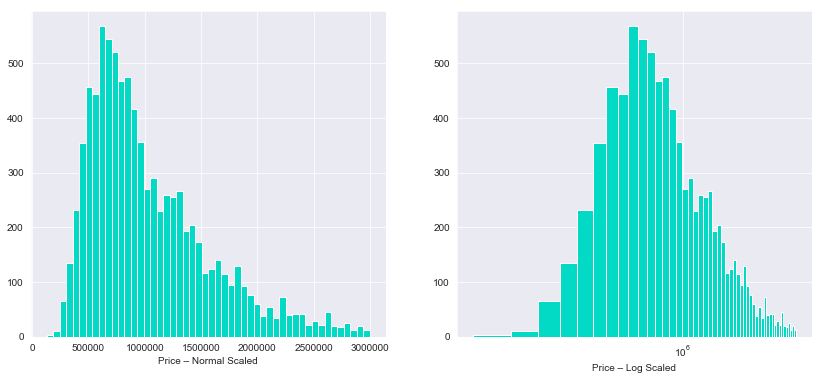

In [35]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(mel.Price, bins=50, color='#03DAC6')
plt.xlabel('Price – Normal Scaled')
plt.subplot(1,2,2)
plt.hist(mel.Price, bins=50, color='#03DAC6')
plt.xscale('log')
plt.xlabel('Price – Log Scaled')
plt.show()

### Select K Best

In [36]:
drop_columns = ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname','Price']

from sklearn.feature_selection import SelectKBest, f_classif

X = mel.drop(drop_columns, 1)
y = mel['Price']

selector=SelectKBest(score_func=f_classif,k=30)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

key_vals = scores.Attribute.loc[scores['P Value']<.05].values

scores.loc[scores['P Value']<.05]

,Attribute,F Score,P Value,Support
7,BuildingArea,3.796228,0.000000e+00,True
0,Rooms,3.019128,1.792290e-225,True
20,Type_u,2.915703,1.277560e-210,True
3,Bedroom2,2.824134,1.636934e-197,True
18,Type_h,2.215557,8.106600e-113,True
4,Bathroom,2.192211,1.034342e-109,True
15,Age,2.002586,3.888005e-85,True
8,YearBuilt,2.000341,7.459981e-85,True
22,Method_S,1.584983,3.453904e-37,True
10,Longtitude,1.508227,9.184155e-30,True


## Modeling

In [49]:
X = mel[key_vals]
y = mel['Price']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X,y)

#X = StandardScaler().fit_transform(X)
#y = StandardScaler().fit_transform(y)

# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, uint8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


### Linear Regression

In [50]:
from datetime import datetime
start_time = datetime.now()

from sklearn import metrics
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_train, y_train)
# Set Up Predictor
ypred_reg = reg.predict(x_test)

print('Coefficients:')
print(reg.coef_)
print('\nIntercept:')
print(reg.intercept_)

print('\nTrain Percentage accuracy:')
print(reg.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(reg.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(reg, x_train, y_train, cv = 5))

print("\nMAE:", metrics.mean_absolute_error(y_test, ypred_reg))
print('MSE:', metrics.mean_squared_error(y_test, ypred_reg))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_reg)))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Coefficients:
[ 1.19972338e+03  1.08784398e+05 -1.70581216e+05  6.94186633e+03
  1.24080744e+05  1.63868828e+05  3.08226588e+04  2.74889718e+04
  2.40108317e+04  9.77844368e+05 -3.23928273e+04 -9.32042779e+05
  3.33809466e+04 -2.61623445e+03  2.84602609e+04 -2.03532211e+02
  4.58015889e+04  4.58015889e+04 -1.08400784e+04  7.46459982e-01]

Intercept:
-237097198.87129757

Train Percentage accuracy:
0.6605068785648065

Test Percentage accuracy:
0.6465118732937479

Cross Validation:
[0.62290913 0.66071453 0.66911225 0.64625016 0.67538729]

MAE: 231423.8991784462
MSE: 102338708422.84644
RMSE: 319904.21757589636

Duration: 0:00:00.044964


### KNN

In [55]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=20, algorithm='auto')
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

#print('Coefficients:')
#print(knn.coef_)
#print('\nIntercept:')
#print(knn.intercept_)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print("\nMAE:", metrics.mean_absolute_error(y_test, ypred_knn))
print('MSE:', metrics.mean_squared_error(y_test, ypred_knn))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_knn)))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6925888606400407

Test Percentage accuracy:
0.6279234299915756

Cross Validation:
[0.64939874 0.61510473 0.65451206 0.58241457 0.61031239]

MAE: 224779.44615207374
MSE: 107720267619.36351
RMSE: 328207.6592941784

Duration: 0:00:00.232919


### Decision Tree

In [56]:
start_time = datetime.now()
from sklearn import tree

dec_tr = tree.DecisionTreeRegressor(
    max_features=3,
    max_depth=6,
    random_state = 1337
)

dec_tr.fit(x_train, y_train)
# Set Up Predictor
ypred_dec_tr = dec_tr.predict(x_test)

print('\nTrain Percentage accuracy:')
print(dec_tr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(dec_tr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(dec_tr, x_train, y_train, cv = 5))

print("\nMAE:", metrics.mean_absolute_error(y_test, ypred_dec_tr))
print('MSE:', metrics.mean_squared_error(y_test, ypred_dec_tr))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_dec_tr)))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6416094296477945

Test Percentage accuracy:
0.6044641544834887

Cross Validation:
[0.6251598  0.61262965 0.65373171 0.6086821  0.59843516]

MAE: 234190.70416852066
MSE: 114511986420.22832
RMSE: 338396.19740805053

Duration: 0:00:00.044173


### Gradient Boosted Decision Tree

In [42]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingRegressor(loss='huber', max_depth=4 , n_estimators=50 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

print("\nMAE:", metrics.mean_absolute_error(y_test, ypred_clf))
print('MSE:', metrics.mean_squared_error(y_test, ypred_clf))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_clf)))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.8392707843285687

Test Percentage accuracy:
0.8077288548429212

Cross Validation:
[0.81576348 0.81447608 0.8262936  0.806177   0.7943206 ]

MAE: 156743.36705428374
MSE: 55664615515.38456
RMSE: 235933.49807813336

Duration: 0:00:02.802004


### Random Forest

In [43]:
start_time = datetime.now()
rfc = ensemble.RandomForestRegressor(n_estimators=50, max_depth=10)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print("\nMAE:", metrics.mean_absolute_error(y_test, ypred_rfc))
print('MSE:', metrics.mean_squared_error(y_test, ypred_rfc))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, ypred_rfc)))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.9099531444822706

Test Percentage accuracy:
0.8177888347239408

Cross Validation:
[0.82411979 0.80719541 0.82567595 0.81406684 0.79741375]

MAE: 153524.27589596785
MSE: 52752140470.249886
RMSE: 229678.34131726457

Duration: 0:00:06.073074


### PCA for SVR

In [44]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1','pc2','pc3'])

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, uint8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int8, uint8, int16, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [45]:
X = principalDf
Y = y = mel['Price']

# to split a training and test sample
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [46]:
from sklearn.svm import SVR

svr = SVR(kernel='sigmoid', gamma='scale', verbose=True)
svr.fit(x_train, y_train)
ypred_svr = svr.predict(x_test)

print('\nTrain Percentage accuracy:')
print(svr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(svr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(svr, x_train, y_train, cv = 5))

[LibSVM]
Train Percentage accuracy:
-0.0715589925355653

Test Percentage accuracy:
-0.07126787901095866

Cross Validation:
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][-0.06223283 -0.07754149 -0.07327713 -0.08965936 -0.06293669]


## Conclusion